<h1> What Makes a Good Airbnb Listing? </h1>
<h2> Supervised Learning </h2>
<p> <em> Hong Kong, Hong Kong, China </em> </p>

<img src="hong kong.jpg" width=409 height=512 />

<h2>Questions:</h2> <br>
1. Can we predict Airbnb listing price? <br>
2. Can we predict the rating of an Airbnb listing? <br>

<h2>Setup</h2>

<h3>Imports</h3>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import langid
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect.lang_detect_exception import LangDetectException
from langdetect import detect
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

<h3>Load Data</h3>

In [4]:
listings = pd.read_csv('listings.csv')
#sentfeatures = pd.read_csv('sentiment_features.csv')

##Replace NaN values with 0s and convert the price strings into floats, then drop outliers
listings.fillna({'neighborhood_overview':"NoOverview"}, inplace=True)
listings['neighbourhood_group_cleansed'] = listings['neighbourhood_cleansed']
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings = listings.drop(listings.index[listings['price'] >= 5500])

<h2>Visualize Data</h2>

In [5]:
sns.set_theme()
sns.set_palette("husl", 9) #crest

<h3>Amount of Listings for Each Neighborhood</h3>
<p>For Hong Kong, these are about 18 neighborhoods. As seen in the graph below, a majority of Airbnb listings are found in Yau Tsim Mong and Wan Chai.</p>

<a href=https://theculturetrip.com/asia/china/hong-kong/articles/hong-kongs-5-trendiest-neighborhoods/>Neighborhoods of Hong Kong</a>

No handles with labels found to put in legend.


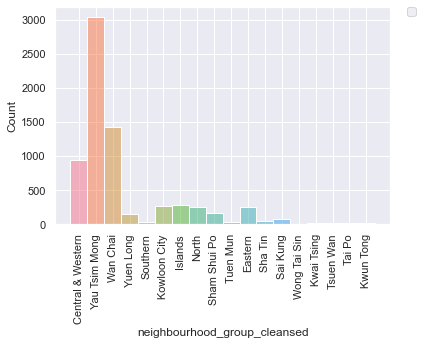

In [7]:
sns.histplot(data=listings, x="neighbourhood_group_cleansed", hue="neighbourhood_group_cleansed")
plt.xticks(rotation='vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<h3>Distribution of Listing Prices</h3>
<p>Prices appear to be between <strong>at most</strong> around 2000 USD for a majority of the listings, but there are a small number of more expensive listings as well.</p>

<AxesSubplot:xlabel='price', ylabel='Density'>

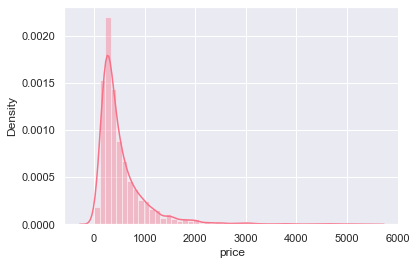

In [9]:
sns.distplot(listings['price'])

<h3>Price Distributions for Each Neighborhood</h3>
<p>Hong Kong seems to have a lot more expensive listings, as opposed to NYC and Amsterdam. Out of these expensive listings, Central & West, Yau Tsim Mong, and Wan Chai, have the most versus the rest.</p>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Central & Western'),
  Text(1, 0, 'Yau Tsim Mong'),
  Text(2, 0, 'Wan Chai'),
  Text(3, 0, 'Yuen Long'),
  Text(4, 0, 'Southern'),
  Text(5, 0, 'Kowloon City'),
  Text(6, 0, 'Islands'),
  Text(7, 0, 'North'),
  Text(8, 0, 'Sham Shui Po'),
  Text(9, 0, 'Tuen Mun'),
  Text(10, 0, 'Eastern'),
  Text(11, 0, 'Sha Tin'),
  Text(12, 0, 'Sai Kung'),
  Text(13, 0, 'Wong Tai Sin'),
  Text(14, 0, 'Kwai Tsing'),
  Text(15, 0, 'Tsuen Wan'),
  Text(16, 0, 'Tai Po'),
  Text(17, 0, 'Kwun Tong')])

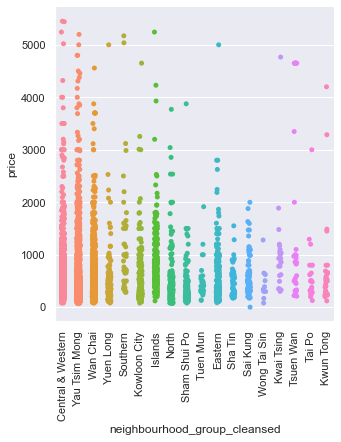

In [12]:
sns.catplot(data=listings, x="neighbourhood_group_cleansed", y="price")
plt.xticks(rotation='vertical')

<h3>Price Distributions for Room Type : Each Neighborhood Group</h3>
<p>There are 4 room types: Private rooms, Shared rooms, Entire homes/apartments, and Hotel Rooms. [Hotel rooms are the 4th set of bars, but the axis isn't labeling them for some reason]</p>

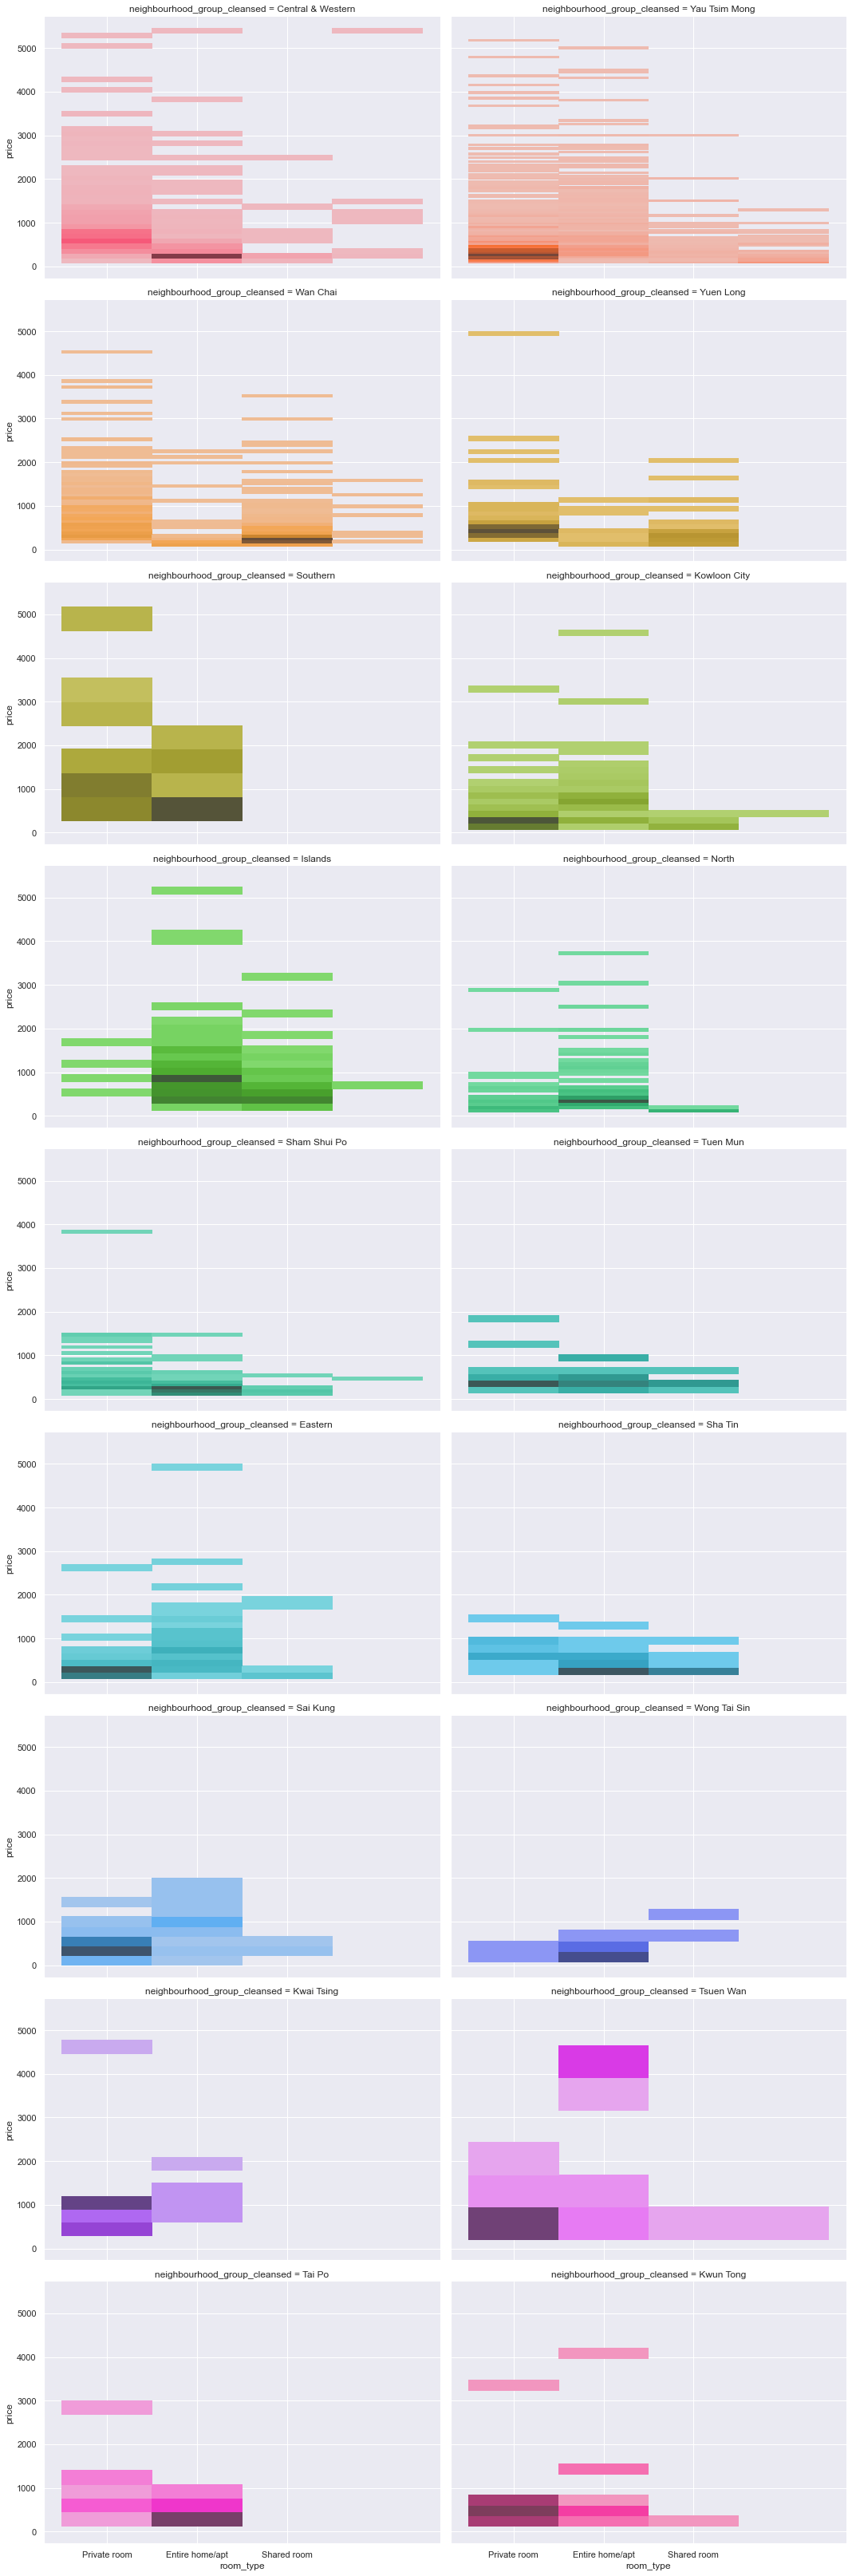

In [13]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=2, height=5, 
                  aspect=1.5, hue="neighbourhood_group_cleansed")
g.map(sns.histplot, "room_type", "price")

<h3>Price Distributions for Accommodation Size : Each Neighborhood Group</h3>
<p>Listing price goes up as the accommodation size goes up, save one.</p>

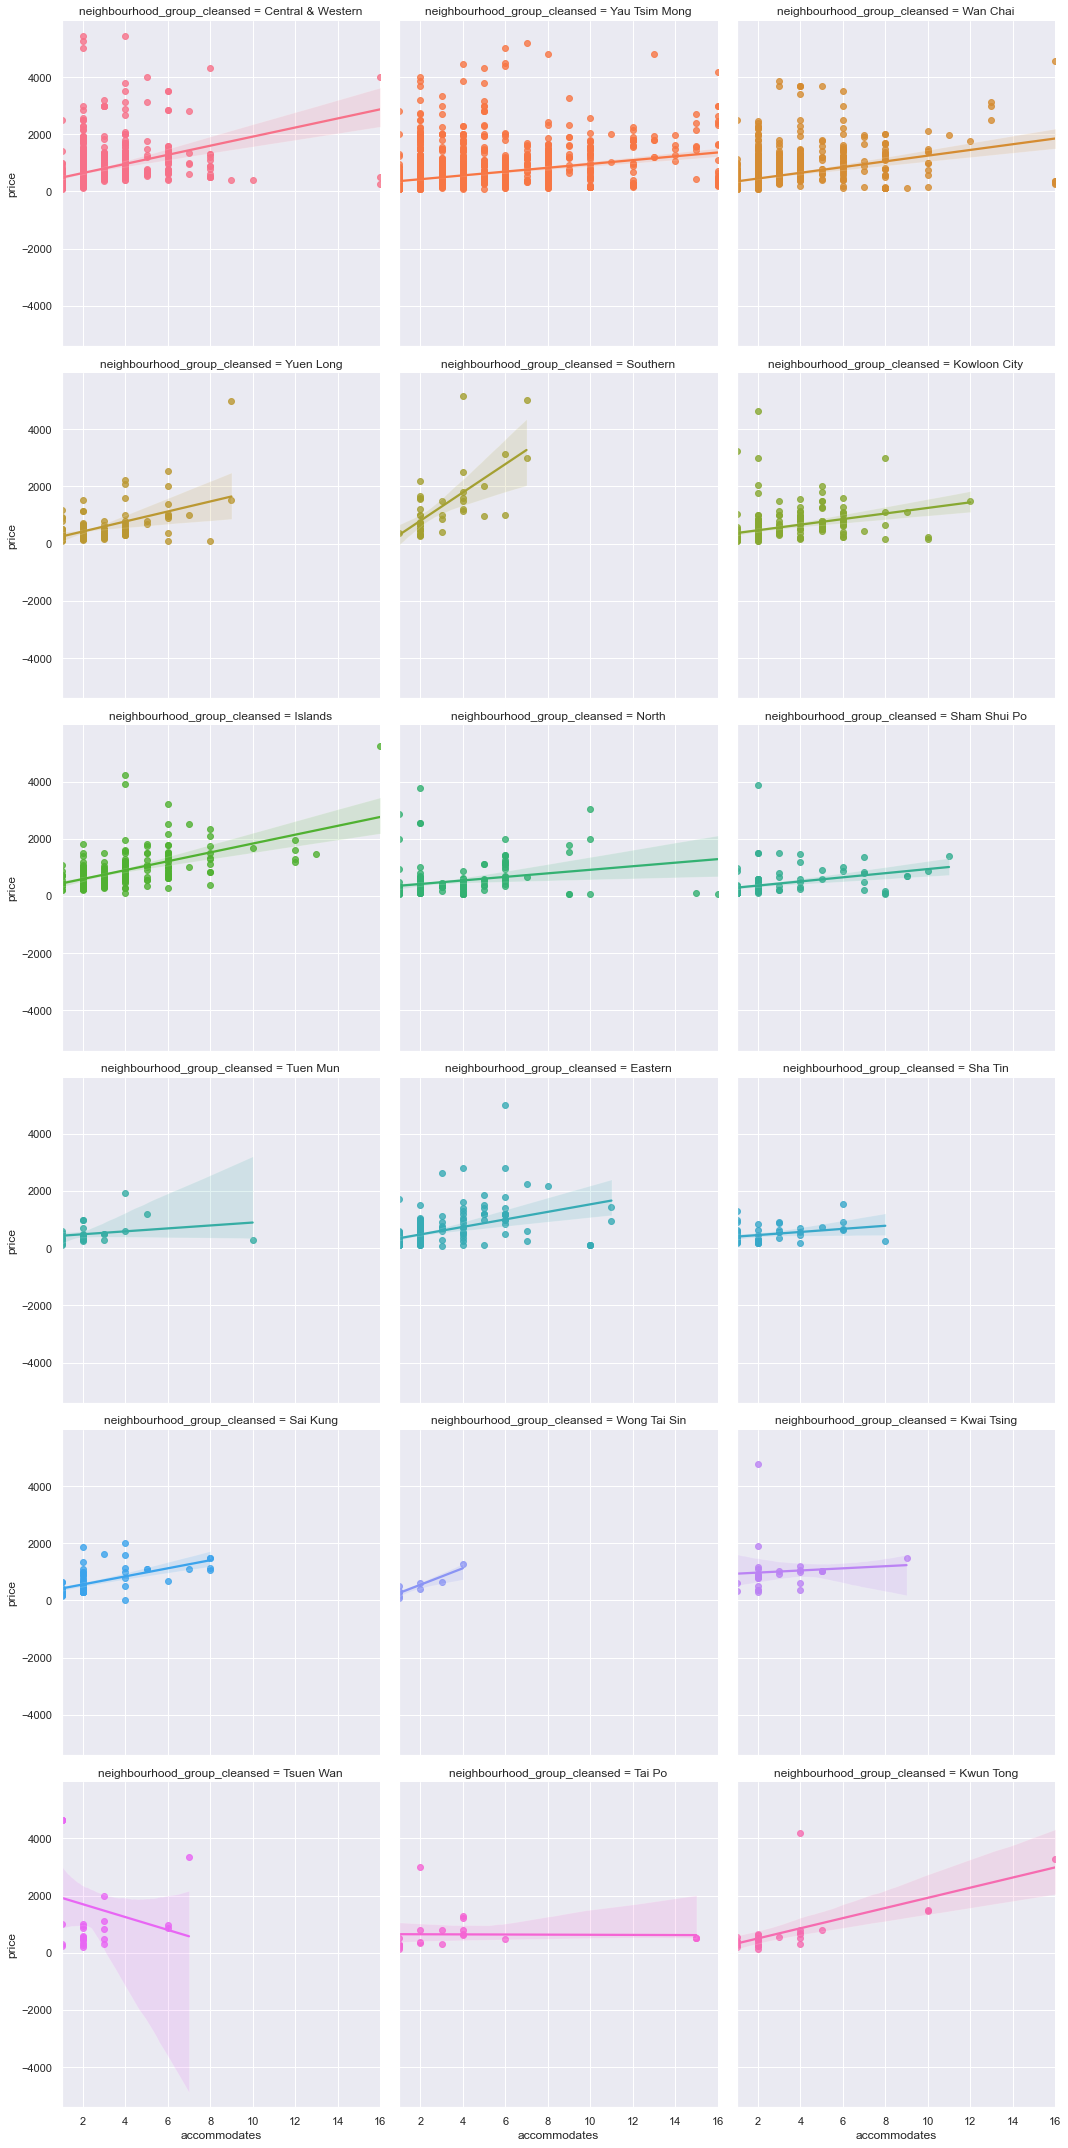

In [15]:
g = sns.FacetGrid(listings, col="neighbourhood_group_cleansed", col_wrap=3, height=5, hue="neighbourhood_group_cleansed")
g.map(sns.regplot, "accommodates", "price")

<h2> Clean & Preprocess Data </h2>

<p>Most ML algorithms cannot handle categorical variables unless we convert them to numerical values. Since our data is a mix of numerical and categorical, we go column by column to do the preprocessing.</p>

In [16]:
listings_cleaned_price = listings.copy()
listings_cleaned_price = listings_cleaned_price.rename(columns={"neighbourhood_cleansed": "neighborhood", 
                                                               "neighbourhood_group_cleansed": "neighborhood_group"})

#listings_cleaned_price = sentfeatures.merge(listings_cleaned_price, how="inner", left_on=['listing_id'],right_on=['id'])

<h3>Drop Misc Columns from Data</h3>

In [17]:
# Drop URLs from Dataframe, as they are unlikely to have much influence on prediction results
listings_cleaned_price.drop(['listing_url', 'picture_url', 'host_url', 'host_thumbnail_url', 'host_picture_url'], 
                   axis=1, inplace=True)

# Drop other misc. columns from Dataframe, as they are not too influential on price or are empty/same values
listings_cleaned_price.drop(['id','scrape_id','last_scraped','host_id','host_name',
                             'host_location','host_verifications', 'host_has_profile_pic','neighbourhood',
                             'bathrooms','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
                             'minimum_minimum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                             'maximum_nights_avg_ntm','calendar_updated','calendar_last_scraped', 'first_review',
                             'last_review','license','host_is_superhost','instant_bookable'], 
                   axis=1, inplace=True)

<h3> Replace Bathrooms in Text Form with Integer/Float Version </h3>

In [18]:
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('[^\d.]', '', regex=True)
listings_cleaned_price['bathrooms_text'] = listings_cleaned_price['bathrooms_text'].replace('', '0.5', regex=True).astype(float)

<h3> Replace List of Amenities with How Many Amenities </h3>

In [19]:
listings_cleaned_price['amenities'] = listings_cleaned_price['amenities'].apply(lambda x: x.strip('][').split(', ')).map(len)

<h3>Replace Neighborhood Overview Feature Values with Text Analysis Values</h3><br>
<a href=https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Hong_Kong>Tourist Attractions in Hong Kong</a><br>
<p>Encoding neighborhood_overview values: Many of the overview texts contain names of famous tourist attractions in Hong Kong. If we construct a word bank of these different locations, then we can replace this column with the number of attractions it's close to, i.e. len of that list</p>

In [20]:
list_of_attractions = ['Disneyland', 'Ocean Park', 'Avenue of Stars', 'Lamma Winds', 
                       'Victoria Harbour', 'Che Kung Miu', 'Tian Tan Buddha', 'Victoria Park', 'Victoria Peak',
                       'Hong Kong Wetland Park', 'Hung Shing Yeh Beach', 'Repulse Bay', 'International Finance Centre', 'Peak Tower', 
                       "Engineer's Office of the Former Pumping Station", 'Ping Chau', 'Lamma Island', 'New Town Plaza', 'Tung Choi Street', 
                       'Yau Ma Tei Fruit Market', 'Man Mo Temple', 'Madame Tussauds', 'Macau Ferry Pier', 'Sun Yat Sun Memorial Park', 
                       'Michelin', 'Causeway Bay', 'Central', "Prince's Terrace", 'Space Museum', 
                       'Star Ferry', 'Waterfront Promenade', 'Pulse 3D Light Show', 'Cultural Center', 'SOHO', 
                       'The Peak', 'points of interest']

list_of_attractions = [x.lower() for x in list_of_attractions]

for i, listing in listings_cleaned_price.iterrows():
    text = listings_cleaned_price.at[i, 'neighborhood_overview'].lower()
    count = len([loc for loc in list_of_attractions if loc in text])
    listings_cleaned_price.at[i, 'neighborhood_overview'] = count


<h3>Replace Name and Description Feature Text with Sentiment Analysis Values</h3><br>

In [71]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Meghana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [72]:
def stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence

def grammar(string):
    # add whatever else you think you might have to account for
    result = str(string)
    result = result.replace('/', ' ')
    result = result.replace('*', ' ')
    result = result.replace('&', ' ')
    result = result.replace('>', ' ')
    result = result.replace('<', ' ')
    result = result.replace('-', ' ')
    result = result.replace('...', ' ')
    result = result.replace('@', ' ')
    result = result.replace('#', ' ')
    result = result.replace('-', ' ')
    result = result.replace('$', ' ')
    result = result.replace('%', ' ')
    result = result.replace('+', ' ')
    result = result.replace('=', ' ')
    return result

def to_single_string(list_of_strings):
    return " ".join(list_of_strings)

In [73]:
names = listings_cleaned_price['name'].astype(str)
descriptions = listings_cleaned_price['description'].astype(str)

In [74]:
name_gram = names.apply(grammar)
descp_gram = descriptions.apply(grammar)
langid.set_languages(['en', 'es', 'zh'])
not_en_title = []
not_en_index_title = []
not_en_descp = []
not_en_descp_index = []

i = 0
for title in name_gram:
    if langid.classify(title)[0] != 'en':
        not_en_title += [title]
        not_en_index_title += [name_gram.index[i]]
    i += 1
    
i = 0
for descp in descp_gram:
    if langid.classify(descp)[0] != 'en':
        not_en_descp += [descp]
        not_en_descp_index+=[descp_gram.index[i]]
    i += 1

In [75]:
for i in name_gram.index:
    if name_gram[i] in not_en_title:
        name_gram[i] = ''
names = name_gram.apply(stop_words)

for i in descp_gram.index:
    if descp_gram[i] in not_en_descp:
        descp_gram[i] = ''
descriptions = descp_gram.apply(stop_words)

descriptions = descriptions.apply(to_single_string)
names = names.apply(to_single_string)

In [76]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def sentiment_score(string):
    result = sentiment_analyzer.polarity_scores(string)
    return result

def compound_score(sent):
    return sent.get('compound')

def polarity(sent):
    compound = sent.get('compound')
    if(compound >= 0.05):
        return 1
    elif(compound <= -0.05):
        return -1
    return 0

sentiment_names = names.apply(sentiment_score)
sentiment_descriptions = descriptions.apply(sentiment_score)

sentiment_names_m1 = sentiment_names.apply(compound_score)
sentiment_descriptions_m1 = sentiment_descriptions.apply(compound_score)

sentiment_names_m2 = sentiment_names.apply(polarity)
sentiment_descriptions_m2 = sentiment_descriptions.apply(polarity)

In [77]:
listings_cleaned_price['sent_names_m1'] = sentiment_names_m1
listings_cleaned_price['sent_names_m2'] = sentiment_names_m2
listings_cleaned_price['sent_descp_m1'] = sentiment_descriptions_m1
listings_cleaned_price['sent_descp_m2'] = sentiment_descriptions_m2

listings_cleaned_price.drop(columns = ['name', 'description'], inplace = True)

<h3>Convert rest of the categorical variables into dummy/indicator variables.</h3> <br>
<a href=https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html>sklearn.preprocessing.LabelEncoder Documentation </a><br>
<a href=https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html>pandas.get_dummies Documentation</a><br>

<p> We can discuss preferences between the two, if needed. </p>

In [21]:
le = preprocessing.LabelEncoder()  

listings_cleaned_price['neighborhood_group'] = le.fit_transform(listings_cleaned_price['neighborhood_group'].astype(str))
listings_cleaned_price['neighborhood'] = le.fit_transform(listings_cleaned_price['neighborhood'].astype(str))
listings_cleaned_price['room_type'] = le.fit_transform(listings_cleaned_price['room_type'].astype(str))
listings_cleaned_price['property_type'] = le.fit_transform(listings_cleaned_price['property_type'].astype(str))
listings_cleaned_price['has_availability']=le.fit_transform(listings_cleaned_price['has_availability'].astype(str))

listings_cleaned_price['name'] = le.fit_transform(listings_cleaned_price['name'].astype(str))
listings_cleaned_price['description'] = le.fit_transform(listings_cleaned_price['description'].astype(str))
listings_cleaned_price['host_since'] = le.fit_transform(listings_cleaned_price['host_since'].astype(str))
listings_cleaned_price['host_about'] = le.fit_transform(listings_cleaned_price['host_about'].astype(str))
listings_cleaned_price['host_response_time'] = le.fit_transform(listings_cleaned_price['host_response_time'].astype(str))
listings_cleaned_price['host_response_rate'] = le.fit_transform(listings_cleaned_price['host_response_rate'].astype(str))
listings_cleaned_price['host_acceptance_rate'] = le.fit_transform(listings_cleaned_price['host_acceptance_rate'].astype(str))
listings_cleaned_price['host_neighbourhood'] = le.fit_transform(listings_cleaned_price['host_neighbourhood'].astype(str))
listings_cleaned_price['host_identity_verified'] = le.fit_transform(listings_cleaned_price['host_identity_verified'].astype(str))

# listings_cleaned_price['neighborhood_overview'] = le.fit_transform(listings_cleaned_price['neighborhood_overview'].astype(str))
# listings_cleaned_price['bathrooms_text'] = le.fit_transform(listings_cleaned_price['bathrooms_text'].astype(str))
# listings_cleaned_price['amenities'] = le.fit_transform(listings_cleaned_price['amenities'].astype(str))

<h3> Save New CSV </h3>

In [22]:
listings_cleaned_price.to_csv('listings_cleaned_hongkong.csv', index=False)

<h2>Linear Regression</h2>

In [23]:
listings_cleaned_price = pd.read_csv('listings_cleaned_hongkong.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Root mean squared error: 464.12
Coefficient of determination: 0.36

k = 2
Root mean squared error: 444.05
Coefficient of determination: 0.46

k = 3
Root mean squared error: 462.31
Coefficient of determination: 0.46

k = 4
Root mean squared error: 416.90
Coefficient of determination: 0.41

k = 5
Root mean squared error: 413.28
Coefficient of determination: 0.44

k = 6
Root mean squared error: 412.70
Coefficient of determination: 0.34

k = 7
Root mean squared error: 546.88
Coefficient of determination: 0.28

k = 8
Root mean squared error: 447.87
Coefficient of determination: 0.37

k = 9
Root mean squared error: 404.19
Coefficient of determination: 0.44

k = 10
Root mean squared error: 475.71
Coefficient of determination: 0.40



<AxesSubplot:>

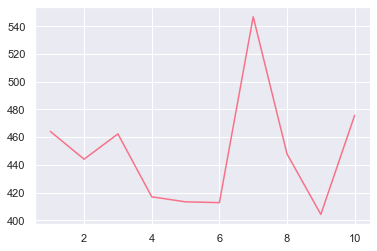

In [24]:
best_lr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    lr = LinearRegression()
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lr.fit(X_train, y_train)
    
    y_preds = np.round(lr.predict(X_test), decimals=2)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_lr_idx[0] = train_index
        best_lr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [25]:
lr = LinearRegression()

train_index, test_index = best_lr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

lr.fit(X_train, y_train)
y_preds = np.round(lr.predict(X_test), decimals=2)

Predicted Price Range:  -296.62 1710.72
Actual Price Range:  92.0 4500.0


Actual Values  Predicted Values
0           690.0           1061.42
1          1379.0            933.98
2           250.0            302.13
3           115.0            228.75
4           364.0            365.88
5           329.0            407.41
6           329.0            271.07
7           291.0            406.51
8           328.0            435.77
9           247.0            257.75
10         2500.0           1382.80
11          674.0            880.73
12          713.0            866.60
13          636.0            649.20
14          804.0            481.18
15         1736.0           1522.53
16          400.0            575.62
17         1100.0           1192.41
18          550.0            917.40
19          422.0            374.77

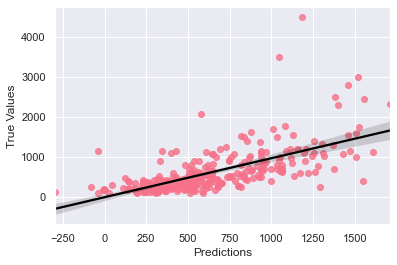

In [26]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

<h3>Get Feature Importances</h3><br>
<p>We can fit a LinearRegression model on the regression dataset and retrieve the coef_ property that contains the coefficients found for each input variable.

These coefficients can provide the basis for a crude feature importance score. This assumes that the input variables have the same scale or have been scaled prior to fitting a model.</p>

latitude -1797.3053111806412
longitude -638.2171109281201
room_type -164.16446394690553
review_scores_value -50.69361968356001
host_response_time -46.492042789329936
review_scores_accuracy -29.581493545683376
calculated_host_listings_count_shared_rooms -25.172390132569426
calculated_host_listings_count_entire_homes -22.21695492899605
calculated_host_listings_count_private_rooms -16.77324009704506
neighborhood_overview -14.31553635184625
beds -10.559999758990308
availability_60 -6.37438545399023
number_of_reviews_ltm -4.943527803449383
review_scores_location -3.021944251979966
neighborhood_group -2.593523943685191
neighborhood -2.5935239436236412
minimum_nights -1.467353821134658
property_type -1.02795006596228
host_identity_verified -0.617316992645543
number_of_reviews -0.5873945619427725
availability_90 -0.2505507349577126
host_neighbourhood -0.09290962074194352
host_since -0.054056854265573294
maximum_nights -0.047483446356404405
host_acceptance_rate -0.03216713698594452
has_availabi

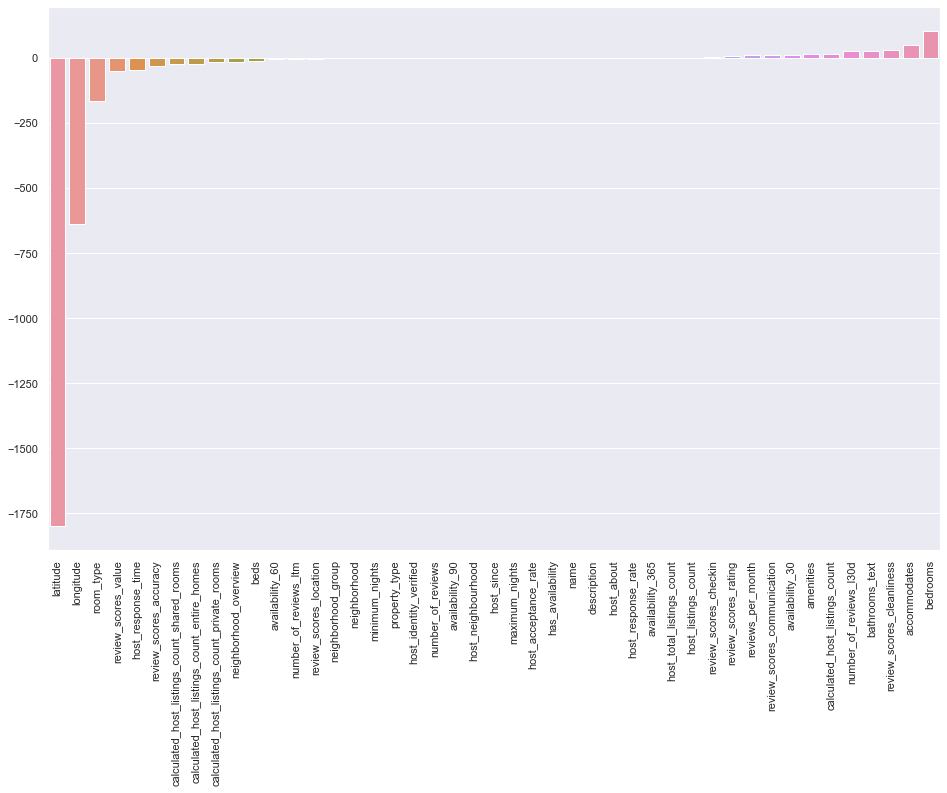

In [27]:
# get importance
importance = lr.coef_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    #print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
for k, v in sorted_imp:
    print(k, v)
# plot feature importance
fig = plt.gcf()
fig.set_size_inches( 16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Random Forest Regressor</h2>

In [28]:
listings_cleaned_price = pd.read_csv('listings_cleaned_hongkong.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

X = listings_cleaned_price.copy()
y = X.pop('price')

k = 1
Mean absolute error: 203.82
Root mean squared error: 427.17
Coefficient of determination: 0.46

k = 2
Mean absolute error: 189.52
Root mean squared error: 352.84
Coefficient of determination: 0.66

k = 3
Mean absolute error: 217.36
Root mean squared error: 410.76
Coefficient of determination: 0.57

k = 4
Mean absolute error: 209.21
Root mean squared error: 401.75
Coefficient of determination: 0.45

k = 5
Mean absolute error: 181.86
Root mean squared error: 383.44
Coefficient of determination: 0.52

k = 6
Mean absolute error: 192.77
Root mean squared error: 364.93
Coefficient of determination: 0.48

k = 7
Mean absolute error: 234.76
Root mean squared error: 424.90
Coefficient of determination: 0.57

k = 8
Mean absolute error: 195.97
Root mean squared error: 407.52
Coefficient of determination: 0.47

k = 9
Mean absolute error: 171.81
Root mean squared error: 330.22
Coefficient of determination: 0.62

k = 10
Mean absolute error: 199.34
Root mean squared error: 423.53
Coefficient of 

<AxesSubplot:>

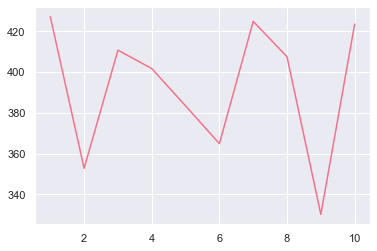

In [29]:
best_regr_idx = [None, None]
best_rmse = 9999
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_lst = []
k = []

i = 1
for train_index, test_index in kfold.split(X, y):
    regr = RandomForestRegressor(random_state=42)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    regr.fit(X_train, y_train)
    
    y_preds = np.round(regr.predict(X_test), decimals=2)
    mae = mean_absolute_error(y_test, y_preds)
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r2 = r2_score(y_test, y_preds)
    
    print("k =", i)
    # The mean absolute error
    print('Mean absolute error: %.2f' % mae)
    # The mean squared error
    print('Root mean squared error: %.2f' % rmse)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f' % r2)
    print()
    
    rmse_lst.append(rmse)
    k.append(i)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_regr_idx[0] = train_index
        best_regr_idx[1] = test_index
    
    i += 1
    
sns.lineplot(x = k, y = rmse_lst)

In [30]:
regr = RandomForestRegressor(random_state=42)

train_index, test_index = best_regr_idx
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

regr.fit(X_train, y_train)
y_preds = np.round(regr.predict(X_test), decimals=2)

Predicted Price Range:  103.57 2445.64
Actual Price Range:  92.0 4500.0


Actual Values  Predicted Values
0           690.0           1133.46
1          1379.0           1320.59
2           250.0            446.77
3           115.0            117.62
4           364.0            424.71
5           329.0            413.27
6           329.0            430.35
7           291.0            301.32
8           328.0            376.05
9           247.0            217.89
10         2500.0           2287.87
11          674.0            837.90
12          713.0            685.26
13          636.0            538.98
14          804.0            660.33
15         1736.0           1214.68
16          400.0            453.79
17         1100.0           1272.63
18          550.0            953.65
19          422.0            427.30

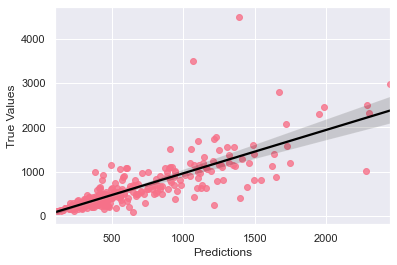

In [31]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

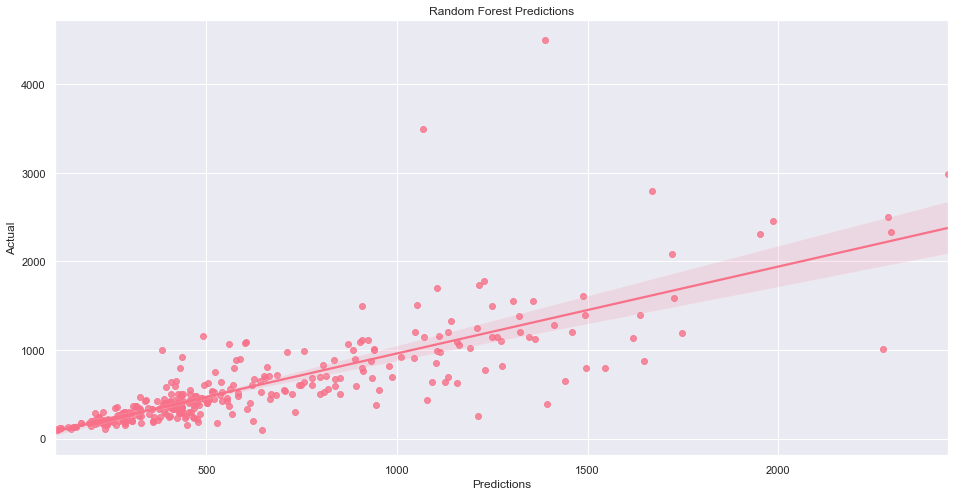

In [32]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Random Forest Predictions")
plt.show()

<h3>Get Feature Importances</h3><br>
<p>We can fit a RandomForestRegressor model on the regression dataset and retrieve the feature_importances_ property.
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.</p>

Feature 0: name, Score: 0.03096
Feature 1: description, Score: 0.02973
Feature 2: neighborhood_overview, Score: 0.00415
Feature 3: host_since, Score: 0.02534
Feature 4: host_about, Score: 0.02826
Feature 5: host_response_time, Score: 0.01113
Feature 6: host_response_rate, Score: 0.01310
Feature 7: host_acceptance_rate, Score: 0.01154
Feature 8: host_neighbourhood, Score: 0.01668
Feature 9: host_listings_count, Score: 0.00821
Feature 10: host_total_listings_count, Score: 0.00764
Feature 11: host_identity_verified, Score: 0.00290
Feature 12: neighborhood, Score: 0.00666
Feature 13: neighborhood_group, Score: 0.00624
Feature 14: latitude, Score: 0.09472
Feature 15: longitude, Score: 0.03915
Feature 16: property_type, Score: 0.02632
Feature 17: room_type, Score: 0.03972
Feature 18: accommodates, Score: 0.03392
Feature 19: bathrooms_text, Score: 0.03863
Feature 20: bedrooms, Score: 0.26671
Feature 21: beds, Score: 0.00894
Feature 22: amenities, Score: 0.04903
Feature 23: minimum_nights, Sco

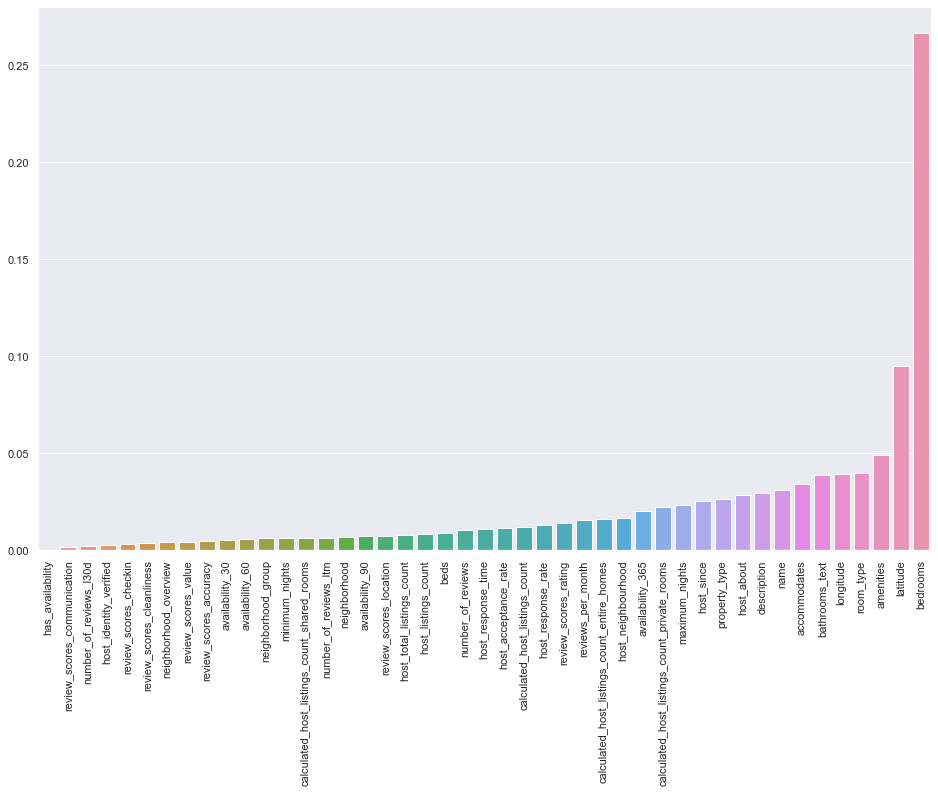

In [33]:
# get importance
importance = regr.feature_importances_
imp_dict = dict()
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature %0d: %s, Score: %.5f' % (i, X.columns[i], v))
    imp_dict[X.columns[i]] = v
    
sorted_imp = sorted(imp_dict.items(), key=lambda kv: kv[1])
# plot feature importance
fig = plt.gcf()
fig.set_size_inches(16, 10)
plt.xticks(rotation='vertical')
sns.barplot(x=[k for k, v in sorted_imp], y=[v for k, v in sorted_imp])
plt.show()

<h2>Neural Network - Price</h2>

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [35]:
listings_cleaned_price = pd.read_csv('listings_cleaned_hongkong.csv')
listings_cleaned_price = listings_cleaned_price.dropna()

listings_cleaned_price

name  description  neighborhood_overview  host_since  host_about  \
0     1140          768                      2           3         610   
2     1520         1935                      0           6         571   
3     2362          507                      0          13         876   
4     2420         2413                      2           6         571   
5     4582         1407                      0           6         571   
...    ...          ...                    ...         ...         ...   
6969  6733         4857                      0         986        1095   
6989  3854          613                      0        1449         890   
7053  4073         2602                      1        1452         890   
7058  4815         3550                      0         561         340   
7094   544         1731                      0         914         746   

      host_response_time  host_response_rate  host_acceptance_rate  \
0                      3                   1                    20   
2                      3                  53                     1   
3                      0                   0                    67   
4                      3                  53                     1   
5                      3                  53                     1   
...                  ...                 ...                   ...   
6969                   4                   1                     1   
6989                   4                   1                     1   
7053                   4                   1                    28   
7058                   4                  49                     1   
7094                   4                   1                    65   

      host_neighbourhood  host_listings_count  ...  review_scores_cleanliness  \
0                     99                  2.0  ...                        9.0   
2                     99                 12.0  ...                        9.0   
3                     65                  0.0  ...                       10.0   
4                     99                 12.0  ...                       10.0   
5                     99                 12.0  ...                        9.0   
...                  ...                  ...  ...                        ...   
6969                 138                  0.0  ...                       10.0   
6989                  13                  1.0  ...                        5.0   
7053                  11                  1.0  ...                        9.0   
7058                 108                  6.0  ...                       10.0   
7094                  66                  2.0  ...                       10.0   

      review_scores_checkin  review_scores_communication  \
0                      10.0                         10.0   
2                      10.0                         10.0   
3                      10.0                         10.0   
4                      10.0                         10.0   
5                      10.0                          9.0   
...                     ...                          ...   
6969                   10.0                         10.0   
6989                    9.0                          9.0   
7053                   10.0                         10.0   
7058                   10.0                         10.0   
7094                   10.0                         10.0   

      review_scores_location  review_scores_value  \
0                       10.0                  9.0   
2                       10.0                  9.0   
3                       10.0                  9.0   
4                       10.0                 10.0   
5                       10.0                  9.0   
...                      ...                  ...   
6969                    10.0                 10.0   
6989                     9.0                  6.0   
7053                    10.0                  9.0   
7058                     9.0                  9.0   

In [36]:
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(listings_cleaned_price.copy())

# multiplied_by = scaler.scale_[13]
# added = scaler.min_[13]

# X = pd.DataFrame(X, columns=listings_cleaned_price.columns.values)
X = listings_cleaned_price.copy()
y = X.pop('price')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 45)                2070      
_________________________________________________________________
dense_1 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [39]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
80/80 [==============================] - 0s 665us/step - loss: 414030.7812 - mean_squared_error: 414030.7812
Epoch 2/100
80/80 [==============================] - 0s 657us/step - loss: 356581.0000 - mean_squared_error: 356581.0000
Epoch 3/100
80/80 [==============================] - 0s 598us/step - loss: 344380.5312 - mean_squared_error: 344380.5312
Epoch 4/100
80/80 [==============================] - 0s 573us/step - loss: 330432.7188 - mean_squared_error: 330432.7188
Epoch 5/100
80/80 [==============================] - 0s 573us/step - loss: 319919.3750 - mean_squared_error: 319919.3750
Epoch 6/100
80/80 [==============================] - 0s 549us/step - loss: 304830.7812 - mean_squared_error: 304830.7812
Epoch 7/100
80/80 [==============================] - 0s 524us/step - loss: 299697.4062 - mean_squared_error: 299697.4062
Epoch 8/100
80/80 [==============================] - 0s 561us/step - loss: 285110.6562 - mean_squared_error: 285110.6562
Epoch 9/100
80/80 [=============

80/80 [==============================] - 0s 524us/step - loss: 141255.9375 - mean_squared_error: 141255.9375
Epoch 69/100
80/80 [==============================] - 0s 536us/step - loss: 146592.7656 - mean_squared_error: 146592.7656
Epoch 70/100
80/80 [==============================] - 0s 536us/step - loss: 138989.0469 - mean_squared_error: 138989.0469
Epoch 71/100
80/80 [==============================] - 0s 524us/step - loss: 137575.2656 - mean_squared_error: 137575.2656
Epoch 72/100
80/80 [==============================] - 0s 536us/step - loss: 140454.0625 - mean_squared_error: 140454.0625
Epoch 73/100
80/80 [==============================] - 0s 536us/step - loss: 133649.9688 - mean_squared_error: 133649.9688
Epoch 74/100
80/80 [==============================] - 0s 586us/step - loss: 141236.7031 - mean_squared_error: 141236.7031
Epoch 75/100
80/80 [==============================] - 0s 474us/step - loss: 137933.1875 - mean_squared_error: 137933.1875
Epoch 76/100
80/80 [=================

In [40]:
y_preds = np.round(nn.predict(X_test), decimals=2)

# y_preds -= added
# y_preds /= multiplied_by

# y_test -= added
# y_test /= multiplied_by

Predicted Price Range:  -19.22 3612.54
Actual Price Range:  84.0 5038.0


Actual Values  Predicted Values
0           380.0        412.450012
1           410.0        289.829987
2           728.0        733.500000
3           600.0        740.369995
4          1950.0       1107.459961
5           288.0        572.250000
6           400.0        437.700012
7           355.0        497.910004
8           709.0        420.209991
9           893.0       1159.520020
10          926.0        512.210022
11         1029.0       1061.270020
12          129.0        176.309998
13          660.0        965.729980
14         3000.0       1120.439941
15          786.0       1366.979980
16          420.0        784.570007
17          200.0        296.049988
18          550.0        337.500000
19          800.0        510.209991

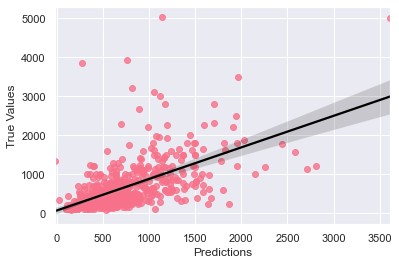

In [41]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

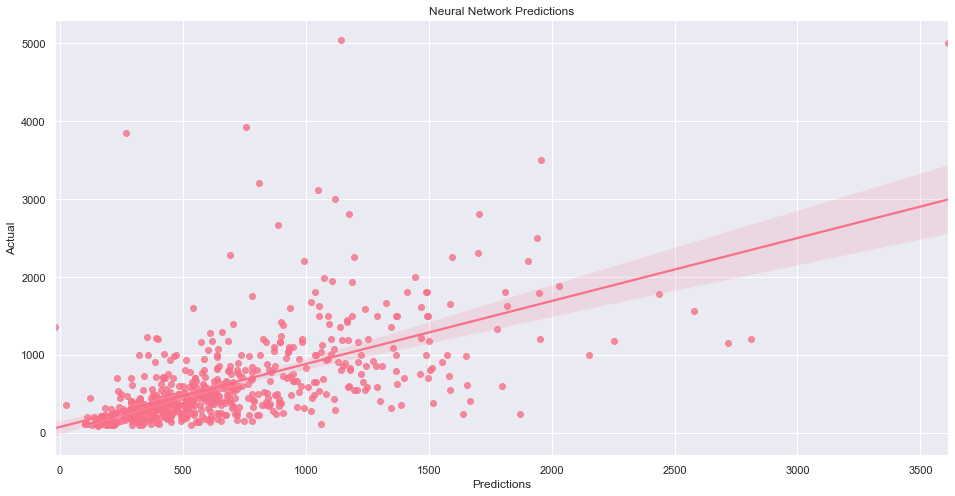

In [42]:
import plotly.graph_objs as go
import plotly.express as px

title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [43]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 289.62
Root mean squared error: 483.28
Coefficient of determination: 0.33



<h2>Neural Network - Ratings</h2>

In [44]:
listings_cleaned_price = pd.read_csv('listings_cleaned_hongkong.csv')
listings_cleaned_price = listings_cleaned_price.dropna()
listings_cleaned_price = listings_cleaned_price.drop(listings_cleaned_price.index[listings_cleaned_price['review_scores_rating'] <= 40])

listings_cleaned_price

name  description  neighborhood_overview  host_since  host_about  \
0     1140          768                      2           3         610   
2     1520         1935                      0           6         571   
3     2362          507                      0          13         876   
4     2420         2413                      2           6         571   
5     4582         1407                      0           6         571   
...    ...          ...                    ...         ...         ...   
6969  6733         4857                      0         986        1095   
6989  3854          613                      0        1449         890   
7053  4073         2602                      1        1452         890   
7058  4815         3550                      0         561         340   
7094   544         1731                      0         914         746   

      host_response_time  host_response_rate  host_acceptance_rate  \
0                      3                   1                    20   
2                      3                  53                     1   
3                      0                   0                    67   
4                      3                  53                     1   
5                      3                  53                     1   
...                  ...                 ...                   ...   
6969                   4                   1                     1   
6989                   4                   1                     1   
7053                   4                   1                    28   
7058                   4                  49                     1   
7094                   4                   1                    65   

      host_neighbourhood  host_listings_count  ...  review_scores_cleanliness  \
0                     99                  2.0  ...                        9.0   
2                     99                 12.0  ...                        9.0   
3                     65                  0.0  ...                       10.0   
4                     99                 12.0  ...                       10.0   
5                     99                 12.0  ...                        9.0   
...                  ...                  ...  ...                        ...   
6969                 138                  0.0  ...                       10.0   
6989                  13                  1.0  ...                        5.0   
7053                  11                  1.0  ...                        9.0   
7058                 108                  6.0  ...                       10.0   
7094                  66                  2.0  ...                       10.0   

      review_scores_checkin  review_scores_communication  \
0                      10.0                         10.0   
2                      10.0                         10.0   
3                      10.0                         10.0   
4                      10.0                         10.0   
5                      10.0                          9.0   
...                     ...                          ...   
6969                   10.0                         10.0   
6989                    9.0                          9.0   
7053                   10.0                         10.0   
7058                   10.0                         10.0   
7094                   10.0                         10.0   

      review_scores_location  review_scores_value  \
0                       10.0                  9.0   
2                       10.0                  9.0   
3                       10.0                  9.0   
4                       10.0                 10.0   
5                       10.0                  9.0   
...                      ...                  ...   
6969                    10.0                 10.0   
6989                     9.0                  6.0   
7053                    10.0                  9.0   
7058                     9.0                  9.0   

In [45]:
X = listings_cleaned_price.copy()
y = X.pop('review_scores_rating')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
nn = Sequential()

# The Input Layer :
nn.add(Dense(45, input_dim = 45, activation='relu'))

# The Hidden Layers :
nn.add(Dense(90, activation='relu'))
nn.add(Dense(45, activation='relu'))

# The Output Layer :
nn.add(Dense(1, activation='linear'))

# Compile the network :
nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 45)                2070      
_________________________________________________________________
dense_5 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_6 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 46        
Total params: 10,351
Trainable params: 10,351
Non-trainable params: 0
_________________________________________________________________


In [47]:
nn.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=True)
y_preds = np.round(nn.predict(X_test), decimals=2)

Epoch 1/100
79/79 [==============================] - 0s 855us/step - loss: 2510.9744 - mean_squared_error: 2510.9744
Epoch 2/100
79/79 [==============================] - 0s 430us/step - loss: 509.4864 - mean_squared_error: 509.4864
Epoch 3/100
79/79 [==============================] - 0s 609us/step - loss: 471.9781 - mean_squared_error: 471.9781
Epoch 4/100
79/79 [==============================] - 0s 622us/step - loss: 350.5327 - mean_squared_error: 350.5327
Epoch 5/100
79/79 [==============================] - 0s 520us/step - loss: 280.7500 - mean_squared_error: 280.7500
Epoch 6/100
79/79 [==============================] - 0s 618us/step - loss: 202.1977 - mean_squared_error: 202.1977
Epoch 7/100
79/79 [==============================] - 0s 493us/step - loss: 182.4448 - mean_squared_error: 182.4448
Epoch 8/100
79/79 [==============================] - 0s 467us/step - loss: 166.5184 - mean_squared_error: 166.5184
Epoch 9/100
79/79 [==============================] - 0s 520us/step - loss: 177

79/79 [==============================] - 0s 555us/step - loss: 58.6181 - mean_squared_error: 58.6181
Epoch 73/100
79/79 [==============================] - 0s 594us/step - loss: 47.9904 - mean_squared_error: 47.9904
Epoch 74/100
79/79 [==============================] - 0s 480us/step - loss: 50.4259 - mean_squared_error: 50.4259
Epoch 75/100
79/79 [==============================] - 0s 417us/step - loss: 51.5202 - mean_squared_error: 51.5202
Epoch 76/100
79/79 [==============================] - 0s 443us/step - loss: 50.0720 - mean_squared_error: 50.0720
Epoch 77/100
79/79 [==============================] - 0s 442us/step - loss: 51.5723 - mean_squared_error: 51.5723
Epoch 78/100
79/79 [==============================] - 0s 468us/step - loss: 60.2936 - mean_squared_error: 60.2936
Epoch 79/100
79/79 [==============================] - 0s 615us/step - loss: 67.8906 - mean_squared_error: 67.8906
Epoch 80/100
79/79 [==============================] - 0s 620us/step - loss: 51.0777 - mean_squared_er

Predicted Price Range:  69.21 155.21
Actual Price Range:  50.0 100.0


Actual Values  Predicted Values
0            98.0         99.120003
1            90.0         94.059998
2            92.0         91.120003
3           100.0        106.930000
4           100.0         94.690002
5            94.0         97.349998
6            92.0         95.050003
7            87.0         93.459999
8            84.0         91.650002
9            95.0         99.059998
10           90.0         98.459999
11           84.0         84.919998
12           98.0         96.470001
13           85.0         92.150002
14           80.0         88.970001
15           91.0         89.940002
16          100.0         90.400002
17          100.0         92.559998
18           80.0         85.410004
19           91.0         98.779999

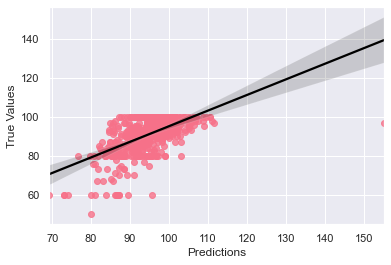

In [48]:
sns.regplot(x = y_preds, y = y_test, fit_reg = True, line_kws={"color": "black"})
plt.xlabel("Predictions")
plt.ylabel("True Values")

print("Predicted Price Range: ", np.min(y_preds), np.max(y_preds))
print("Actual Price Range: ", np.min(y_test), np.max(y_test))

error_diff = pd.DataFrame({'Actual Values': np.array(y_test).flatten(), 'Predicted Values': y_preds.flatten()})
error_diff1 = error_diff.head(20)
error_diff1

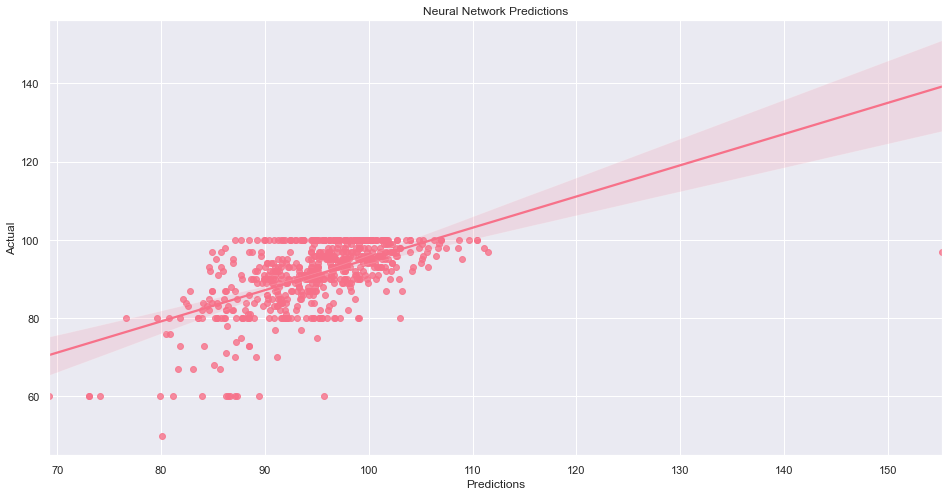

In [49]:
title=['Pred vs Actual']
fig = go.Figure(data=[
    go.Bar(name='Predicted', x=error_diff1.index, y=error_diff['Predicted Values']),
    go.Bar(name='Actual', x=error_diff1.index, y=error_diff['Actual Values'])
])
fig.update_layout(barmode='group')
fig.show()

plt.figure(figsize=(16,8))
sns.regplot(y_preds,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Neural Network Predictions")
plt.show()

In [50]:
mae = mean_absolute_error(y_test, y_preds)
rmse = np.sqrt(mean_squared_error(y_test, y_preds))
r2 = r2_score(y_test, y_preds)

print("Neural Network")
# The mean absolute error
print('Mean absolute error: %.2f' % mae)
# The mean squared error
print('Root mean squared error: %.2f' % rmse)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2)
print()

Neural Network
Mean absolute error: 5.82
Root mean squared error: 8.02
Coefficient of determination: 0.13

